In [1]:
#loading some stuff 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle

In [2]:
#setting system path
import sys
sys.path.append('c:/Users/tpiechowiak/Documents/BEAR/GNOS/sws_machine_learning/')
base_path = 'c:/Users/tpiechowiak/OneDrive - GN Store Nord/GNOS data/'

In [3]:
#now loading all the necessary data files
#now loading the pickle file containing the audiogram data
base_path = 'c:/Users/tpiechowiak/OneDrive - GN Store Nord/GNOS data/'
#now load the demographics data
with open(base_path + "Demographics_Device_Data.pkl", "rb") as input_file:
    demo_data = pickle.load(input_file)
print("Read Demographics and device data")

with open(base_path + 'hi_id_low_cluster.pkl','rb') as input_file:
    low_use_id = pickle.load(input_file)
print('Read low-use cluster ids')

with open(base_path + 'hi_id_ADL_before_return.pkl','rb') as input_file:
    return_id = pickle.load(input_file)
print('Read return ids')


Read Demographics and device data
Read low-use cluster ids
Read return ids


In [4]:
#add low use colums
demo_data['low_use'] = 0
demo_data.loc[demo_data['HearingInstrumentId'].isin(low_use_id),'low_use'] = 1

In [5]:
#add return colum
demo_data['return'] = 0
demo_data.loc[demo_data['HearingInstrumentId'].isin(return_id),'return'] = 1

In [6]:
demographics = demo_data.sort_values('PatientId').drop_duplicates(
    subset=['PatientId','HearingInstrumentId'])

In [28]:
demographics.shape[0]

16450

In [8]:
#now choose the inputs for the classifier 
X = demographics[['CountryCode','BrandName','Gender','UserExperienceLevel','AudClass',
                           'AgeGroup','Formfactor','asym','low_use']].pipe(pd.get_dummies, columns = ['CountryCode',
                                                                                      'BrandName',                                                                                     
                                                                                      'Gender',
                                                                                      'Formfactor',
                                                                                      'AgeGroup'              
                                                                                                ])
#now encode the audiogram classes (based on ordering standard audiograms)
X['AudClass'] = X['AudClass'].map({'N1':0, 'N2':1, 'N3':2, 'N4':3, 'N5':4, 'N6':5,
                                   'N7':6, 'S1':1, 'S2':2, 'S3':3})

Y = demographics['return'].values


In [9]:
X.head(5)

,UserExperienceLevel,AudClass,asym,low_use,CountryCode_AR,CountryCode_AT,CountryCode_AU,CountryCode_BE,CountryCode_BG,CountryCode_BR,...,Formfactor_CIC,Formfactor_ITC,Formfactor_ITE,Formfactor_RIE,AgeGroup_Middle age,AgeGroup_Odd,AgeGroup_Old,AgeGroup_Very Young,AgeGroup_Very old,AgeGroup_Young
3754258,0,2,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3754313,0,5,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4036270,3,3,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4036239,3,3,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4597860,0,2,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


### Now apply a classification tree with ordered Aud Class

In [10]:
#now prepare the Decision Classifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

tr = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=100, min_samples_split=100)
tr.fit(X.values,Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
export_graphviz(tr,out_file='ClassificationTree_returns.dot', feature_names=X.columns, filled=False, rounded=True,
               proportion=True,
               leaves_parallel=True)

In [12]:
from subprocess import call
call(['dot', '-T', 'pdf', 'ClassificationTree_returns.dot', '-o', 'ClassificationTree_returns.pdf'])

0

[Text(0, 0, '0'),
 Text(0, 0, '10'),
 Text(0, 0, '20'),
 Text(0, 0, '30'),
 Text(0, 0, '40'),
 Text(0, 0, '50'),
 Text(0, 0, '60')]

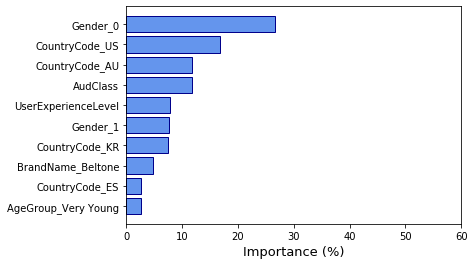

In [13]:
#now plot importance of predictors 
#now plot the sorted importance of the features 
x_ax = X.columns[np.where(tr.feature_importances_ > 0)]
y_ax = tr.feature_importances_[np.where(tr.feature_importances_ > 0)]

fig, ax = plt.subplots()

unsorted_list = [(importance, feature) for feature, importance in 
                  zip(x_ax, y_ax)]
sorted_list = sorted(unsorted_list)
features_sorted = []
importance_sorted = []

for i in sorted_list:
    features_sorted += [i[1]]
    importance_sorted += [i[0]]

#plt.title("Feature importance", fontsize=15)
plt.xlabel("Importance (%)", fontsize=13)

plt.barh(features_sorted,importance_sorted, color="cornflowerblue", edgecolor='darkblue')
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60])

## Now try with amount of average use-time instead of low-usage label as predictor


In [14]:
#load average use time from database 
with open(base_path + "AvgUseTime.pkl", "rb") as input_file:
    avg_use = pickle.load(input_file)
print("Read average use time")

Read average use time


In [15]:
#now try to merge the demographics with average use time and then clean 
demographics = demo_data.merge(avg_use, on='HearingInstrumentId', how='inner').sort_values('PatientId').drop_duplicates(
    subset=['PatientId','HearingInstrumentId'])


In [16]:
#now choose the inputs for the classifier 
X = demographics[['CountryCode','BrandName','Gender','UserExperienceLevel','AudClass',
                           'AgeGroup','Formfactor','asym','AvgUseTime']].pipe(pd.get_dummies, columns = ['CountryCode',
                                                                                      
                                                                                      'BrandName',                                                                                                                                          'Gender',
                                                                                      'Formfactor',
                                                                                      'AgeGroup' ])                                                                                  
                                                                                                
#now encode the audiogram classes (based on ordering standard audiograms)
X['AudClass'] = X['AudClass'].map({'N1':0, 'N2':1, 'N3':2, 'N4':3, 'N5':4, 'N6':5,
                                   'N7':6, 'S1':1, 'S2':2, 'S3':3})

Y = demographics['return'].values


In [17]:
X.keys()[:100]

Index(['UserExperienceLevel', 'AudClass', 'asym', 'AvgUseTime',
       'CountryCode_AR', 'CountryCode_AT', 'CountryCode_AU', 'CountryCode_BE',
       'CountryCode_BR', 'CountryCode_CA', 'CountryCode_CH', 'CountryCode_CL',
       'CountryCode_DE', 'CountryCode_DK', 'CountryCode_ES', 'CountryCode_FI',
       'CountryCode_FR', 'CountryCode_GB', 'CountryCode_HK', 'CountryCode_HU',
       'CountryCode_ID', 'CountryCode_IE', 'CountryCode_IL', 'CountryCode_IN',
       'CountryCode_IS', 'CountryCode_IT', 'CountryCode_JP', 'CountryCode_KR',
       'CountryCode_LB', 'CountryCode_MX', 'CountryCode_MY', 'CountryCode_NL',
       'CountryCode_NO', 'CountryCode_NZ', 'CountryCode_PL', 'CountryCode_SE',
       'CountryCode_SG', 'CountryCode_SI', 'CountryCode_TR', 'CountryCode_US',
       'CountryCode_ZA', 'BrandName_Beltone', 'BrandName_ReSound', 'Gender_0',
       'Gender_1', 'Gender_2', 'Formfactor_BTE', 'Formfactor_ITC',
       'Formfactor_ITE', 'Formfactor_RIE', 'AgeGroup_Middle age',
       'AgeGr

In [18]:
#now do the tree again 
tr = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=100, min_samples_split=100)
tr.fit(X.values,Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [19]:
export_graphviz(tr,out_file='ClassificationTree_returns_average_use.dot', feature_names=X.columns, filled=False, rounded=True,
               proportion=True,
               leaves_parallel=True)

In [20]:
from subprocess import call
call(['dot', '-T', 'pdf', 'ClassificationTree_returns_average_use.dot', '-o', 'ClassificationTree_returns_average_use.pdf'])

0

[Text(0, 0, '0'),
 Text(0, 0, '10'),
 Text(0, 0, '20'),
 Text(0, 0, '30'),
 Text(0, 0, '40'),
 Text(0, 0, '50'),
 Text(0, 0, '60')]

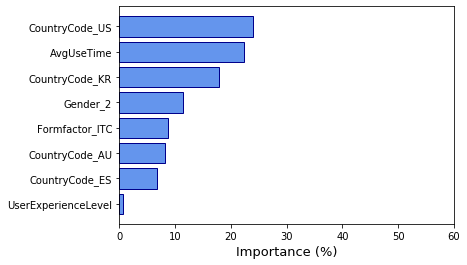

In [21]:
#now plot importance of predictors 
#now plot the sorted importance of the features 
x_ax = X.columns[np.where(tr.feature_importances_ > 0)]
y_ax = tr.feature_importances_[np.where(tr.feature_importances_ > 0)]

fig, ax = plt.subplots()

unsorted_list = [(importance, feature) for feature, importance in 
                  zip(x_ax, y_ax)]
sorted_list = sorted(unsorted_list)
features_sorted = []
importance_sorted = []

for i in sorted_list:
    features_sorted += [i[1]]
    importance_sorted += [i[0]]

#plt.title("Feature importance", fontsize=15)
plt.xlabel("Importance (%)", fontsize=13)

plt.barh(features_sorted,importance_sorted, color="cornflowerblue", edgecolor='darkblue')
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60])

In [22]:
X 

,UserExperienceLevel,AudClass,asym,AvgUseTime,CountryCode_AR,CountryCode_AT,CountryCode_AU,CountryCode_BE,CountryCode_BR,CountryCode_CA,...,Formfactor_BTE,Formfactor_ITC,Formfactor_ITE,Formfactor_RIE,AgeGroup_Middle age,AgeGroup_Odd,AgeGroup_Old,AgeGroup_Very Young,AgeGroup_Very old,AgeGroup_Young
0,3,2,1,10.469831,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
82,3,2,1,10.460591,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
104,0,4,1,0.953997,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
112,0,4,1,1.164919,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
162,0,1,1,11.046254,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761356,0,2,1,0.882907,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
677515,3,0,1,12.893287,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
677553,3,1,1,13.949817,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
876922,0,6,1,7.458313,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [23]:
pd.get_dummies(demographics['StateCode'])

,,AK,AL,AR,AZ,CA,CO,CT,DC,DE,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
82,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
104,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
677515,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
677553,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
876922,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [24]:
import statsmodels.api as sm

mod = sm.OLS(Y, X.values).fit()


In [25]:
print(mod.summary())

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     18.79
Date:                Mon, 21 Sep 2020   Prob (F-statistic):          2.58e-159
Time:                        09:23:08   Log-Likelihood:                -2101.5
No. Observations:               16450   AIC:                             4305.
Df Residuals:                   16399   BIC:                             4698.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0100      0.002      5.003      0.000       0.006       0.014
x